### This notebook is to assess the budget for the different tools that are run for initiatives, app installs, new buyers, and churn.

In [1]:
from google_cloud import BigQuery, Storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import base64
import os
import re

#Cliente BigQuery
AUTH_BIGQUERY = base64.b64decode(os.environ['SECRET_AUTH_BIGQUERY_MODEL'])
bq = BigQuery(AUTH_BIGQUERY)
storage =Storage(AUTH_BIGQUERY)

In [2]:
#  !pip install --upgrade google-api-python-client
# !pip install google-cloud
# !pip install google-cloud-vision
# !pip install --upgrade google-cloud
# !pip install --upgrade google-cloud-bigquery
# !pip install --upgrade google-cloud-storage

In [3]:
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

!pip install pandas --upgrade 
!pip install numpy --upgrade
!pip install scipy --upgrade

### New Buyers

In [4]:
budget_nb = 3700000

In [5]:
spent_nb = bq.execute_response("""
with tools as(
    SELECT sit_site_id,CAST(mkt_tool_id as int64) as CAMPAIGN_ID
    FROM meli-marketing.PUSH.LK_PUSH_BUDGET_COUPON
    where sit_site_id = 'MLM'
        --and tim_month > current_date - 180
    group by 1,2
    )
,
out_ as (
    SELECT 
        pay.SIT_SITE_ID,
        pay_created_dt, 
        SUM(mkt_cpn_amount) as AMOUNT
    FROM  `meli-bi-data.WHOWNER.BT_PAY_PAYMENTS` as pay
    INNER JOIN `meli-bi-data.WHOWNER.BT_MKT_COUPON_V2` as cpn
        on pay.pay_payment_id = cpn.pay_payment_id
        and pay.cus_cust_id_buy = cpn.cus_cust_id_buy
        --AND MKT_CPN_CREATION_DATE > DATE_SUB(CURRENT_DATE() ,INTERVAL 90 DAY)
    INNER JOIN tools t
        on t.CAMPAIGN_ID = cpn.mkt_cpn_campaign_id
        AND t.SIT_SITE_ID = pay.SIT_SITE_ID
    WHERE pay.pay_status_code = 'approved'
        AND pay.pay_created_dt BETWEEN DATE'2022-03-01' and CURRENT_DATE()
    GROUP BY 1,2)
select 
    SIT_SITE_ID,
    pay_created_dt, 
    AMOUNT,
    SUM(AMOUNT) OVER (PARTITION BY SIT_SITE_ID  ORDER BY pay_created_dt ASC) AS ACC_AMOUNT 
    from out_""")

In [6]:
spent_nb

,SIT_SITE_ID,pay_created_dt,AMOUNT,ACC_AMOUNT
0,MLM,2022-03-01,16800.000000000,16800.000000000
1,MLM,2022-03-02,20000.000000000,36800.000000000
2,MLM,2022-03-03,1000.000000000,37800.000000000
3,MLM,2022-03-04,25400.000000000,63200.000000000
4,MLM,2022-03-07,100.000000000,63300.000000000
5,MLM,2022-03-10,57450.000000000,120750.000000000
6,MLM,2022-03-11,87000.000000000,207750.000000000
7,MLM,2022-03-12,51300.000000000,259050.000000000
8,MLM,2022-03-13,76500.000000000,335550.000000000
9,MLM,2022-03-14,85050.000000000,420600.000000000


In [7]:
spent_nb["pay_created_dt"] = pd.to_datetime(spent_nb.pay_created_dt)
spent_nb["AMOUNT"] = spent_nb.AMOUNT.astype(float)
spent_nb["ACC_AMOUNT"] = spent_nb.ACC_AMOUNT.astype(float)

In [8]:
spent_nb["TARGET"] = spent_nb["ACC_AMOUNT"]*100/budget_nb

Text(0.5, 1.0, 'Budget spent: 36.37 %')

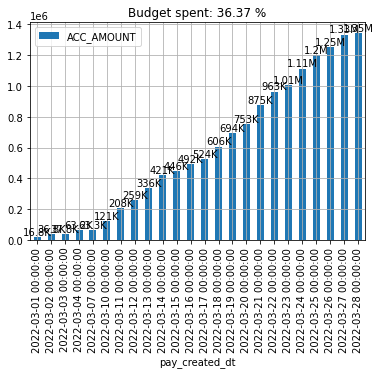

In [9]:
ax = spent_nb.plot.bar(x = 'pay_created_dt',y = 'ACC_AMOUNT')
plt.grid()
ax.bar_label(ax.containers[0],labels = [human_format(z) for z in spent_nb.ACC_AMOUNT],label_type='edge')
plt.title(f'Budget spent: {np.round(max(spent_nb["TARGET"]),2)} %')

[Text(0, 0, '16.8K'),
 Text(0, 0, '20K'),
 Text(0, 0, '1K'),
 Text(0, 0, '25.4K'),
 Text(0, 0, '100'),
 Text(0, 0, '57.4K'),
 Text(0, 0, '87K'),
 Text(0, 0, '51.3K'),
 Text(0, 0, '76.5K'),
 Text(0, 0, '85K'),
 Text(0, 0, '25.2K'),
 Text(0, 0, '45.9K'),
 Text(0, 0, '32.3K'),
 Text(0, 0, '82K'),
 Text(0, 0, '88.2K'),
 Text(0, 0, '58.6K'),
 Text(0, 0, '122K'),
 Text(0, 0, '88.3K'),
 Text(0, 0, '43.8K'),
 Text(0, 0, '106K'),
 Text(0, 0, '85.2K'),
 Text(0, 0, '55.8K'),
 Text(0, 0, '79K'),
 Text(0, 0, '12.6K')]

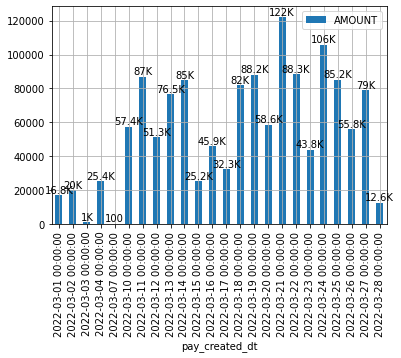

In [10]:
ax = spent_nb.plot.bar(x = 'pay_created_dt',y = 'AMOUNT')
plt.grid()
ax.bar_label(ax.containers[0],labels = [human_format(z) for z in spent_nb.AMOUNT],label_type='edge')

### CHURN

In [11]:
budget_churn120 = 3999000
budget_churn140 = 4101000

In [12]:
spent_churn = bq.execute_response("""
WITH TOOLS as(
    SELECT CAST(CAMPAIGN_ID as INT64) as CAMPAIGN_ID,
          cp.mtc_site_id as SIT_SITE_ID,MTC_NAME, MTC_CMG_BUDGET,ACTIVO
     FROM `meli-marketing.MODELLING.V_BT_MKT_TOOLS_CAMPAIGN` cp
     WHERE cp.mtc_site_id in ('MLM')
     AND lower(cp.MTC_NAME) LIKE '%churncupon%'
     --AND cp.mtc_start_date BETWEEN DATE_SUB(CURRENT_DATE() ,INTERVAL 180 DAY) and  CURRENT_DATE()
     )
      SELECT   mkt_cpn_campaign_id,mtc_name,pay_created_dt,pay.sit_site_id,
              SUM(cpn.mkt_cpn_amount) as descuento_lc,AVG(MTC_CMG_BUDGET) as presupuesto,
              MAX(t.ACTIVO) as ACTIVO
      FROM  `meli-bi-data.WHOWNER.BT_PAY_PAYMENTS` as pay
      INNER JOIN `meli-bi-data.WHOWNER.BT_MKT_COUPON_V2` as cpn
          on pay.pay_payment_id = cpn.pay_payment_id
          and pay.cus_cust_id_buy = cpn.cus_cust_id_buy
      INNER JOIN TOOLS t
        ON t.CAMPAIGN_ID = mkt_cpn_campaign_id
        AND pay.SIT_SITE_ID = t.SIT_SITE_ID
      WHERE
          pay.pay_status_code = 'approved'
          AND pay.SIT_SITE_ID in ('MLM') -- MLB no esta funcionando bien...
          AND pay.pay_created_dt between date'2022-03-01' and current_date
      GROUP BY 1,2,3,4; """
                                 )

In [13]:
spent_churn.mtc_name.value_counts()

CHURNCUPON MLM 100    7
CHURNCUPON MLM 80     5
Name: mtc_name, dtype: int64

In [14]:
spent_churn.head(10)

,mkt_cpn_campaign_id,mtc_name,pay_created_dt,sit_site_id,descuento_lc,presupuesto,ACTIVO
0,10189434.000000000,CHURNCUPON MLM 100,2022-03-23,MLM,280.000000000,4100000.000000000,1
1,10189434.000000000,CHURNCUPON MLM 100,2022-03-15,MLM,14000.000000000,4100000.000000000,1
2,10189434.000000000,CHURNCUPON MLM 100,2022-03-22,MLM,616140.000000000,4100000.000000000,1
3,10189452.000000000,CHURNCUPON MLM 80,2022-03-14,MLM,460559.420000000,3511600.000000000,1
4,10189434.000000000,CHURNCUPON MLM 100,2022-03-14,MLM,3916299.930000000,4100000.000000000,1
5,10038072.000000000,CHURNCUPON MLM 80,2022-03-01,MLM,8560.000000000,1000000.000000000,0
6,10189434.000000000,CHURNCUPON MLM 100,2022-03-21,MLM,2051419.820000000,4100000.000000000,1
7,10038072.000000000,CHURNCUPON MLM 80,2022-03-09,MLM,377640.000000000,1000000.000000000,0
8,10189452.000000000,CHURNCUPON MLM 80,2022-03-15,MLM,97080.000000000,3511600.000000000,1
9,10189434.000000000,CHURNCUPON MLM 100,2022-03-28,MLM,4200.000000000,4100000.000000000,1


In [15]:
spent_churn["pay_created_dt"] = pd.to_datetime(spent_churn.pay_created_dt)
spent_churn["descuento_lc"] = spent_churn.descuento_lc.astype(float)
spent_churn["mkt_cpn_campaign_id"] = spent_churn.mkt_cpn_campaign_id.astype(np.int64)
spent_churn.sort_values(by = ["pay_created_dt",'mtc_name'], inplace=True)
spent_churn['mtc_name'] = [i.replace(" ", "_") for i in spent_churn.mtc_name]

In [16]:
spent_churn_ = spent_churn.pivot_table(index= ['pay_created_dt'], columns=['mtc_name'],values= 'descuento_lc',fill_value=0 ).reset_index()
spent_churn_['ACC_AMOUNT'] = (spent_churn_.CHURNCUPON_MLM_100 + spent_churn_.CHURNCUPON_MLM_80).cumsum()
spent_churn_['TARGET_TOTAL'] = spent_churn_['ACC_AMOUNT']*100/(budget_churn120+budget_churn140)
spent_churn_['ACC_AMOUNT_120'] =spent_churn_['CHURNCUPON_MLM_80'].cumsum()
spent_churn_['ACC_AMOUNT_140'] =spent_churn_['CHURNCUPON_MLM_100'].cumsum()
spent_churn_['TARGET_140'] = spent_churn_['ACC_AMOUNT_140']*100/budget_churn140
spent_churn_['TARGET_120'] = spent_churn_['ACC_AMOUNT_120']*100/budget_churn120

In [17]:
spent_churn_.head(10)

mtc_name,pay_created_dt,CHURNCUPON_MLM_100,CHURNCUPON_MLM_80,ACC_AMOUNT,TARGET_TOTAL,ACC_AMOUNT_120,ACC_AMOUNT_140,TARGET_140,TARGET_120
0,2022-03-01,200.00,8560.00,8760.00,0.108148,8560.00,200.00,0.004877,0.214054
1,2022-03-09,0.00,377640.00,386400.00,4.770370,386200.00,200.00,0.004877,9.657414
2,2022-03-10,0.00,102960.00,489360.00,6.041481,489160.00,200.00,0.004877,12.232058
3,2022-03-14,3916299.93,460559.42,4866219.35,60.076782,949719.42,3916499.93,95.501096,23.748923
4,2022-03-15,14000.00,97080.00,4977299.35,61.448140,1046799.42,3930499.93,95.842476,26.176530
5,2022-03-21,2051419.82,0.00,7028719.17,86.774311,1046799.42,5981919.75,145.864905,26.176530
6,2022-03-22,616140.00,0.00,7644859.17,94.380977,1046799.42,6598059.75,160.889045,26.176530
7,2022-03-23,280.00,0.00,7645139.17,94.384434,1046799.42,6598339.75,160.895873,26.176530
8,2022-03-28,4200.00,0.00,7649339.17,94.436286,1046799.42,6602539.75,160.998287,26.176530


Text(0.5, 1.0, 'Budget spent: 161.0 %')

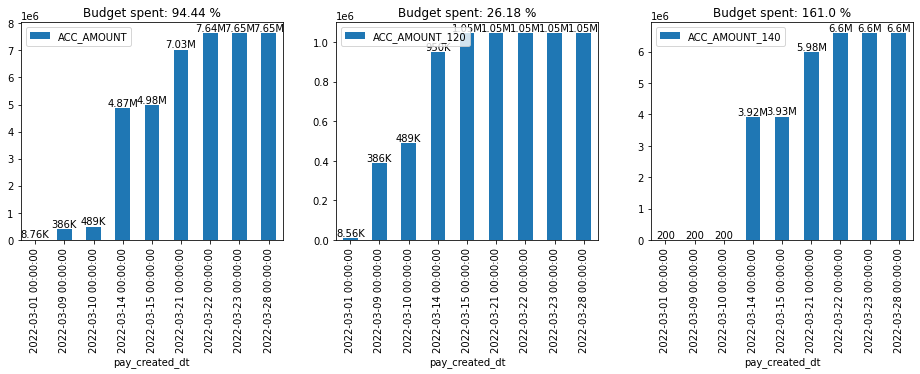

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,4))
ax1 = spent_churn_.plot.bar(x = 'pay_created_dt', y = 'ACC_AMOUNT',ax = ax1)
ax1.bar_label(ax1.containers[0],labels = [human_format(z) for z in spent_churn_.ACC_AMOUNT],label_type='edge')
ax1.set_title(f'Budget spent: {np.round(max(spent_churn_["TARGET_TOTAL"]),2)} %')

ax2 = spent_churn_.plot.bar(x = 'pay_created_dt', y = 'ACC_AMOUNT_120',ax = ax2)
ax2.bar_label(ax2.containers[0],labels = [human_format(z) for z in spent_churn_.ACC_AMOUNT_120],label_type='edge')
ax2.set_title(f'Budget spent: {np.round(max(spent_churn_["TARGET_120"]),2)} %')

ax3 = spent_churn_.plot.bar(x = 'pay_created_dt', y = 'ACC_AMOUNT_140',ax = ax3)
ax3.bar_label(ax3.containers[0],labels = [human_format(z) for z in spent_churn_.ACC_AMOUNT_140],label_type='edge')
ax3.set_title(f'Budget spent: {np.round(max(spent_churn_["TARGET_140"]),2)} %')

In [19]:
spent_churn_.pay_created_dt.diff().fillna('1 days')/np.timedelta64(1, 'D')

0    1.0
1    8.0
2    1.0
3    4.0
4    1.0
5    6.0
6    1.0
7    1.0
8    5.0
Name: pay_created_dt, dtype: float64

In [20]:
spent_churn_["TARGET_120"].diff().fillna(0)

0     0.000000
1     9.443361
2     2.574644
3    11.516865
4     2.427607
5     0.000000
6     0.000000
7     0.000000
8     0.000000
Name: TARGET_120, dtype: float64

In [21]:
delta = spent_churn_["TARGET_120"].diff()/(spent_churn_.pay_created_dt.diff().fillna('1 days')/np.timedelta64(1, 'D'))

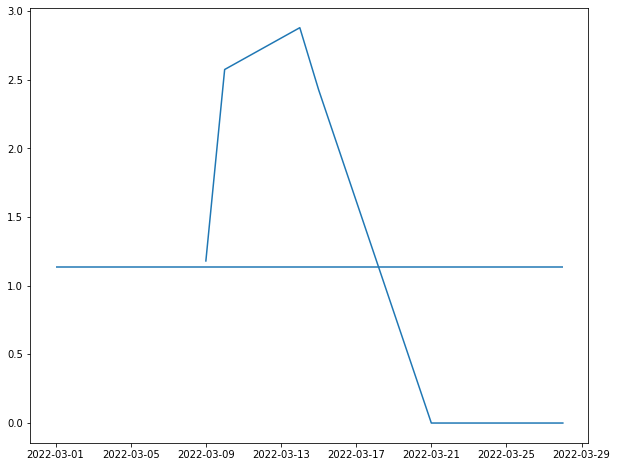

In [22]:
fig,ax =plt.subplots(1,figsize =(10,8))
ax.plot(spent_churn_.pay_created_dt,delta)
ax.hlines(y = np.mean(delta),xmin = min(spent_churn_.pay_created_dt), xmax = max(spent_churn_.pay_created_dt))

In [23]:
np.mean(delta)

1.1327358558389595

[Text(0, 0, '8.56K'),
 Text(0, 0, '378K'),
 Text(0, 0, '103K'),
 Text(0, 0, '461K'),
 Text(0, 0, '97.1K'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

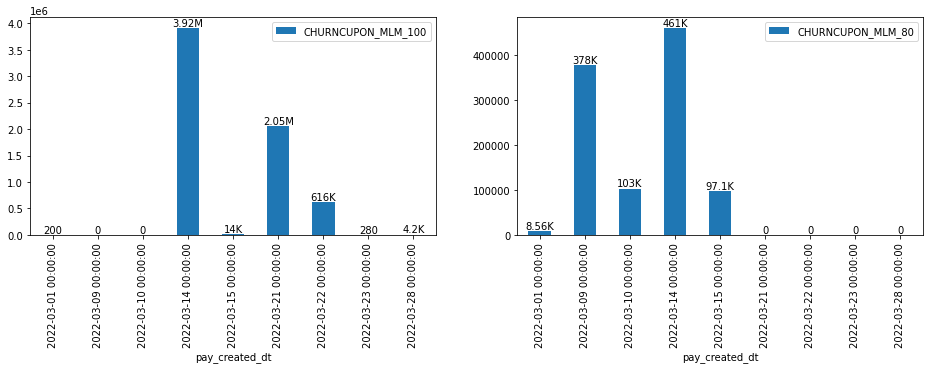

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1 = spent_churn_.plot.bar(x = 'pay_created_dt', y = 'CHURNCUPON_MLM_100',ax = ax1)
ax1.bar_label(ax1.containers[0],labels = [human_format(z) for z in spent_churn_.CHURNCUPON_MLM_100],label_type='edge')

ax2 = spent_churn_.plot.bar(x = 'pay_created_dt', y = 'CHURNCUPON_MLM_80',ax = ax2)
ax2.bar_label(ax2.containers[0],labels = [human_format(z) for z in spent_churn_.CHURNCUPON_MLM_80],label_type='edge')



### INSTALLS

In [25]:
budget_installs_bajo = 250000
budget_installs_medio = 250000
budget_installs_alto = 1000000

In [26]:
spent_installs = bq.execute_response("""WITH TOOLS as(
    SELECT CAST(CAMPAIGN_ID as INT64) as CAMPAIGN_ID,
          cp.mtc_site_id as SIT_SITE_ID,MTC_NAME, MTC_CMG_BUDGET,ACTIVO
     FROM `meli-marketing.MODELLING.V_BT_MKT_TOOLS_CAMPAIGN` cp
     WHERE cp.mtc_site_id in ('MLM')
     AND lower(cp.MTC_NAME) LIKE '%download%'
     --AND cp.mtc_start_date BETWEEN DATE_SUB(CURRENT_DATE() ,INTERVAL 180 DAY) and  CURRENT_DATE()
     )
      SELECT   mkt_cpn_campaign_id,mtc_name,pay_created_dt,pay.sit_site_id,
              SUM(cpn.mkt_cpn_amount) as descuento_lc,AVG(MTC_CMG_BUDGET) as presupuesto,
              MAX(t.ACTIVO) as ACTIVO
      FROM  `meli-bi-data.WHOWNER.BT_PAY_PAYMENTS` as pay
      INNER JOIN `meli-bi-data.WHOWNER.BT_MKT_COUPON_V2` as cpn
          on pay.pay_payment_id = cpn.pay_payment_id
          and pay.cus_cust_id_buy = cpn.cus_cust_id_buy
      INNER JOIN TOOLS t
        ON t.CAMPAIGN_ID = mkt_cpn_campaign_id
        AND pay.SIT_SITE_ID = t.SIT_SITE_ID
      WHERE
          pay.pay_status_code = 'approved'
          AND pay.SIT_SITE_ID in ('MLM') -- MLB no esta funcionando bien...
          AND pay.pay_created_dt between date'2022-03-01' and current_date
      GROUP BY 1,2,3,4;
      """)

In [27]:
spent_installs

,mkt_cpn_campaign_id,mtc_name,pay_created_dt,sit_site_id,descuento_lc,presupuesto,ACTIVO
0,10056906.000000000,APP DOWNLOAD LTV ALTO MLM,2022-03-01,MLM,51720.000000000,500000.000000000,1
1,10185962.000000000,APP DOWNLOAD LTV BAJO MLM,2022-03-22,MLM,2000.000000000,250000.000000000,1
2,10185947.000000000,APP DOWNLOAD LTV MEDIO MLM,2022-03-23,MLM,2700.000000000,250000.000000000,1
3,10185962.000000000,APP DOWNLOAD LTV BAJO MLM,2022-03-10,MLM,10100.000000000,250000.000000000,1
4,10185962.000000000,APP DOWNLOAD LTV BAJO MLM,2022-03-16,MLM,100.000000000,250000.000000000,1
5,10185947.000000000,APP DOWNLOAD LTV MEDIO MLM,2022-03-22,MLM,3100.000000000,250000.000000000,1
6,10185962.000000000,APP DOWNLOAD LTV BAJO MLM,2022-03-14,MLM,14400.000000000,250000.000000000,1
7,10180846.000000000,APP DOWNLOAD LTV ALTO MLM,2022-03-22,MLM,16680.000000000,1000000.000000000,1
8,10185947.000000000,APP DOWNLOAD LTV MEDIO MLM,2022-03-15,MLM,31800.000000000,250000.000000000,1
9,10180846.000000000,APP DOWNLOAD LTV ALTO MLM,2022-03-18,MLM,480.000000000,1000000.000000000,1


In [28]:
spent_installs["pay_created_dt"] = pd.to_datetime(spent_installs.pay_created_dt)
spent_installs["descuento_lc"] = spent_installs.descuento_lc.astype(float)
spent_installs["mkt_cpn_campaign_id"] =spent_installs.mkt_cpn_campaign_id.astype(np.int64)
spent_installs.sort_values(by = ["pay_created_dt",'mtc_name'], inplace=True)
spent_installs['mtc_name'] = [re.sub(' +', ' ', i).replace(" ", "_") for i in spent_installs.mtc_name]

In [29]:
spent_installs_ = spent_installs.pivot_table(index= ['pay_created_dt'], columns=['mtc_name'],values= 'descuento_lc',fill_value=0 ).reset_index()
spent_installs_['ACC_AMOUNT'] = (spent_installs_.APP_DOWNLOAD_LTV_ALTO_MLM + spent_installs_.APP_DOWNLOAD_LTV_MEDIO_MLM + spent_installs_.APP_DOWNLOAD_LTV_BAJO_MLM).cumsum()
spent_installs_['TARGET_TOTAL'] = spent_installs_['ACC_AMOUNT']*100/(budget_installs_bajo+budget_installs_medio+budget_installs_alto)
spent_installs_['ACC_AMOUNT_BAJO'] = spent_installs_.APP_DOWNLOAD_LTV_BAJO_MLM.cumsum()
spent_installs_['ACC_AMOUNT_MEDIO'] = spent_installs_.APP_DOWNLOAD_LTV_MEDIO_MLM.cumsum()
spent_installs_['ACC_AMOUNT_ALTO'] = spent_installs_.APP_DOWNLOAD_LTV_ALTO_MLM.cumsum()
spent_installs_['TARGET_BAJO'] = spent_installs_['ACC_AMOUNT_BAJO']*100/budget_installs_bajo
spent_installs_['TARGET_MEDIO'] = spent_installs_['ACC_AMOUNT_MEDIO']*100/budget_installs_medio
spent_installs_['TARGET_ALTO'] = spent_installs_['ACC_AMOUNT_ALTO']*100/budget_installs_alto

Text(0.5, 1.0, 'Budget spent: 27.9 %')

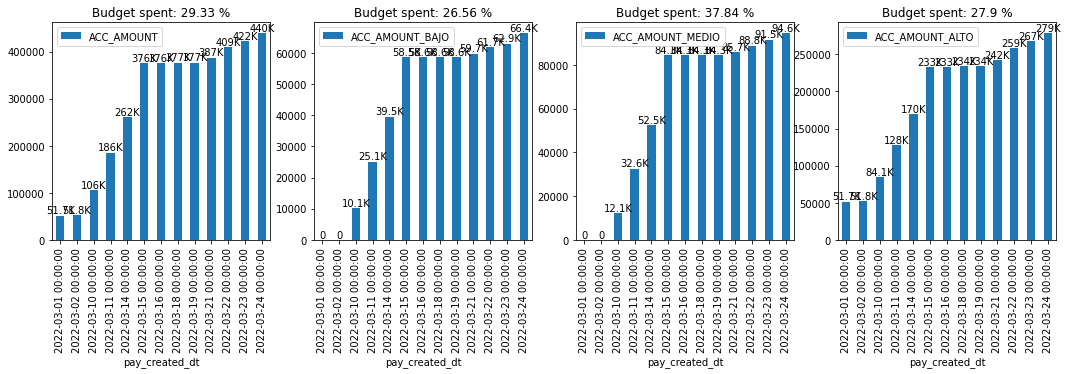

In [30]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (18,4))
ax1 = spent_installs_.plot.bar(x = 'pay_created_dt', y = 'ACC_AMOUNT',ax = ax1)
ax1.bar_label(ax1.containers[0],labels = [human_format(z) for z in spent_installs_.ACC_AMOUNT],label_type='edge')
ax1.set_title(f'Budget spent: {np.round(max(spent_installs_["TARGET_TOTAL"]),2)} %')

ax2 = spent_installs_.plot.bar(x = 'pay_created_dt', y = 'ACC_AMOUNT_BAJO',ax = ax2)
ax2.bar_label(ax2.containers[0],labels = [human_format(z) for z in spent_installs_.ACC_AMOUNT_BAJO],label_type='edge')
ax2.set_title(f'Budget spent: {np.round(max(spent_installs_["TARGET_BAJO"]),2)} %')

ax3 = spent_installs_.plot.bar(x = 'pay_created_dt', y = 'ACC_AMOUNT_MEDIO',ax = ax3)
ax3.bar_label(ax3.containers[0],labels = [human_format(z) for z in spent_installs_.ACC_AMOUNT_MEDIO],label_type='edge')
ax3.set_title(f'Budget spent: {np.round(max(spent_installs_["TARGET_MEDIO"]),2)} %')

ax4 = spent_installs_.plot.bar(x = 'pay_created_dt', y = 'ACC_AMOUNT_ALTO',ax = ax4)
ax4.bar_label(ax4.containers[0],labels = [human_format(z) for z in spent_installs_.ACC_AMOUNT_ALTO],label_type='edge')
ax4.set_title(f'Budget spent: {np.round(max(spent_installs_["TARGET_ALTO"]),2)} %')

[Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '10.1K'),
 Text(0, 0, '15K'),
 Text(0, 0, '14.4K'),
 Text(0, 0, '19K'),
 Text(0, 0, '100'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '1.1K'),
 Text(0, 0, '2K'),
 Text(0, 0, '1.2K'),
 Text(0, 0, '3.5K')]

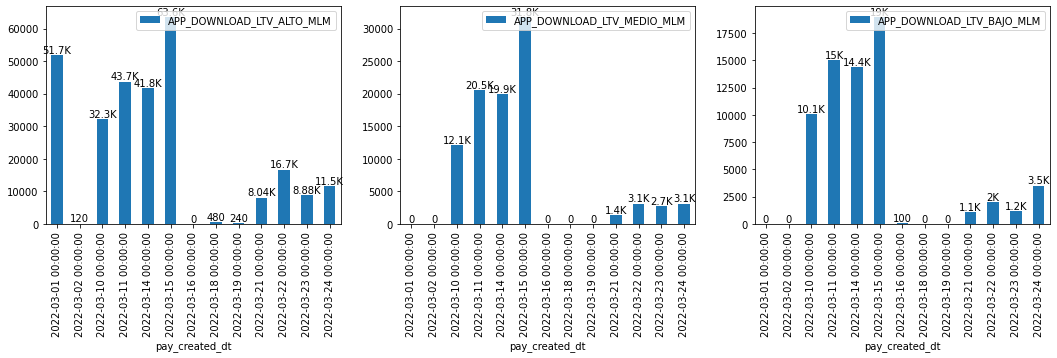

In [31]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (18,4))
ax1 = spent_installs_.plot.bar(x = 'pay_created_dt', y = 'APP_DOWNLOAD_LTV_ALTO_MLM',ax = ax1)
ax1.bar_label(ax1.containers[0],labels = [human_format(z) for z in spent_installs_.APP_DOWNLOAD_LTV_ALTO_MLM],label_type='edge')


ax2 = spent_installs_.plot.bar(x = 'pay_created_dt', y = 'APP_DOWNLOAD_LTV_MEDIO_MLM',ax = ax2)
ax2.bar_label(ax2.containers[0],labels = [human_format(z) for z in spent_installs_.APP_DOWNLOAD_LTV_MEDIO_MLM],label_type='edge')

ax3 = spent_installs_.plot.bar(x = 'pay_created_dt', y = 'APP_DOWNLOAD_LTV_BAJO_MLM',ax = ax3)
ax3.bar_label(ax3.containers[0],labels = [human_format(z) for z in spent_installs_.APP_DOWNLOAD_LTV_BAJO_MLM],label_type='edge')

In [ ]:
#### BASE OUT

In [ ]:
# base = []
# for date in ['2022-03-14','2022-03-15']:
#     q = f"""
#     (
#         with max_fecha as(
#             select max(log_date) as log_date
#             from meli-marketing.MODELLING.PZ_ML_CHURN6M
#             where SIT_SITE_ID = 'MLM'
#             AND log_date = DATE '{date}'
#         ),
#         users_churn as(
#         select CAST(c.CUS_CUST_ID AS INT64) as user_id,
#         c.churn_proba,
#         m.log_date
#         from meli-marketing.MODELLING.PZ_ML_CHURN6M c
#         inner join max_fecha m
#             on m.log_date = c.log_date
#         WHERE c.SIT_SITE_ID = 'MLM'
#             AND NOT EXISTS (SELECT 1 FROM `meli-marketing.MODELLING.PZ_AUTOMATION_PUSH` p 
#                             WHERE INICIATIVA = c.SIT_SITE_ID || '-ML-CHURN' AND FECHA >= DATE '{date}' - 90
#                             AND CAST(p.user_id AS INT64) = c.CUS_CUST_ID
#                             )
#             ORDER BY CHURN_PROBA DESC
#             LIMIT 2000000
#         )
#         SELECT user_id,log_date, CASE WHEN row_number() over(order by CHURN_PROBA desc) <= 1800000 then 'HIGH_CHURN' else 'LOW_CHURN' end as grupo,churn_proba
#         from users_churn
#     )
#     """
#     base_out = bq.execute_response(q)
#     base.append(base_out)

In [ ]:
# out = pd.concat(base,axis = 0)

In [ ]:
# out.sort_values(by = ['log_date'], inplace = True)
# out.reset_index(drop = True, inplace = True)

In [ ]:
# out.head()

In [ ]:
# out.shape

In [ ]:
# # bq.upload_df_to_bigquery(df = out,
# #                          table = 'meli-marketing.TEMP45.BASE_OUT_CHURN',
#                          schema= {'user_id':'INTEGER','log_date':'DATE','grupo':'STRING','churn_proba':'NUMERIC'})

In [ ]:
# bq.execute_response("""select * from  meli-marketing.TEMP45.BASE_OUT_CHURN limit 10""")

In [ ]:
# bq.execute("""
# DROP VIEW `meli-marketing.MODELLING.V_ML_NB_PUSH_AUDIENCIAS`;
# CREATE VIEW `meli-marketing.MODELLING.V_ML_NB_PUSH_AUDIENCIAS` AS
# SELECT CURRENT_DATE() AS SNAPSHOT_DATE,
#       a.cus_cust_id,
#       a.sit_site_id,
#       NULL AS CAN_BUY,
#       NULL AS AUD_INS_DTTM,
#       NULL AS AUD_UPD_DTTM,
#       'NB_PREDICT_PROBA' AS AUD_MSG
#       FROM meli-marketing.MODELLING.NB_PREDICT_PROBA a
#       inner join (
#           -- select 0.301 as TRESH,'MLM' as sit_site_id
#           select 0.041 as TRESH,'MLM' as sit_site_id
#           UNION ALL
#           select 0.091 as TRESH, 'MCO' as sit_site_id
#           UNION ALL
#           select 0.201 as TRESH, 'MLC' as sit_site_id
#           UNION ALL
#           --select 0.1 as TRESH, 'MLB' as sit_site_id
#           select 0.05 as TRESH, 'MLB' as sit_site_id
#         ) t
#         on t.sit_site_id = a.sit_site_id
#       WHERE TYPE_APP='App'
#       and buy_proba >= t.TRESH
#       AND NOT EXISTS (
#                SELECT 1
#                FROM meli-marketing.MKTPUBLIC.V_BT_PUSH_NOTIFICATION_EVENT b
#                WHERE CAMPAIGN_ID like '%NEWBUYERS%'
#                   AND b.EVENT_TYPE in ('shown')
#                   AND b.APP = 'mercadolibre'
#                   AND b.sit_site_id = a.sit_site_id
#                   AND b.SENT_DATE BETWEEN DATE_SUB(CURRENT_DATE(),INTERVAL 2 DAY) AND CURRENT_DATE()
#                   and a.CUS_CUST_ID=b.CUS_CUST_ID
#       )
#       AND a.PROCESS_DATE=CURRENT_DATE()
#       """)

In [ ]:
# bq.execute("""
# DROP VIEW `meli-marketing.MODELLING.V_CHURN_CUPON_AUDIENCIAS_MCO`;
# CREATE VIEW `meli-marketing.MODELLING.V_CHURN_CUPON_AUDIENCIAS_MCO` AS (
# with max_fecha as(
#     select max(log_date) as log_date
#     from meli-marketing.MODELLING.PZ_ML_CHURN6M
#     where SIT_SITE_ID = 'MCO'
# )
# select CAST(CUS_CUST_ID AS INT64) as user_id 
# from meli-marketing.MODELLING.PZ_ML_CHURN6M c
# inner join max_fecha m
#     on m.log_date = c.log_date
# WHERE c.SIT_SITE_ID = 'MCO'
#   AND NOT EXISTS (SELECT 1 FROM `meli-marketing.MODELLING.PZ_AUTOMATION_PUSH` p 
#                   WHERE INICIATIVA = c.SIT_SITE_ID || '-ML-CHURN' AND FECHA >= DATE(CURRENT_DATE()-90)
#                   AND CAST(p.user_id AS INT64) = c.CUS_CUST_ID
#                   )
#   ORDER BY CHURN_PROBA DESC
#   LIMIT 8000
# )
# """
#           )

In [ ]:
# bq.execute("""
# DROP VIEW `meli-marketing.MODELLING.V_ML_NB_PUSH_AUDIENCIAS`;
# CREATE VIEW `meli-marketing.MODELLING.V_ML_NB_PUSH_AUDIENCIAS` AS (
# SELECT CURRENT_DATE() AS SNAPSHOT_DATE,
#       a.cus_cust_id,
#       a.sit_site_id,
#       NULL AS CAN_BUY,
#       NULL AS AUD_INS_DTTM,
#       NULL AS AUD_UPD_DTTM,
#       'NB_PREDICT_PROBA' AS AUD_MSG
#       FROM meli-marketing.MODELLING.NB_PREDICT_PROBA a
#       inner join (
#           -- select 0.301 as TRESH,'MLM' as sit_site_id
#           select 0.041 as TRESH,'MLM' as sit_site_id
#           UNION ALL
#           --select 0.091 as TRESH, 'MCO' as sit_site_id
#           select 0.051 as TRESH, 'MCO' as sit_site_id
#           UNION ALL
#           --select 0.201 as TRESH, 'MLC' as sit_site_id
#           select 0.101 as TRESH, 'MLC' as sit_site_id
#           UNION ALL
#           --select 0.1 as TRESH, 'MLB' as sit_site_id
#           select 0.05 as TRESH, 'MLB' as sit_site_id
#         ) t
#         on t.sit_site_id = a.sit_site_id
#       WHERE TYPE_APP='App'
#       and buy_proba >= t.TRESH
#       AND NOT EXISTS (
#                SELECT 1
#                FROM meli-marketing.MKTPUBLIC.V_BT_PUSH_NOTIFICATION_EVENT b
#                WHERE CAMPAIGN_ID like '%NEWBUYERS%'
#                   AND b.EVENT_TYPE in ('shown')
#                   AND b.APP = 'mercadolibre'
#                   AND b.sit_site_id = a.sit_site_id
#                   AND b.SENT_DATE BETWEEN DATE_SUB(CURRENT_DATE(),INTERVAL 2 DAY) AND CURRENT_DATE()
#                   and a.CUS_CUST_ID=b.CUS_CUST_ID
#       )
#       AND a.PROCESS_DATE=CURRENT_DATE()
# )
# """
#           )